# Morse-Decode. Задача распознавания и декодирования шифра Морзе в зашумленных аудиофайлах.
### Представлен датасет из 30000 аудиофайлов (29000 - обучающая выборка, 1000 - тестовая выборка)
### Проведём анализ данных, подготовим датасеты и напишем модель машинного обучения 

## Анализ данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa

Каждый аудиофайл из датасета (n.opus) имеет размерность (176400,), и длительность 8 секунд.

In [2]:
y, sr = librosa.load(f"train/{1}.opus")
print("Audio shape: ", y.shape)
print("Samplerate: ", sr)

Audio shape:  (176400,)
Samplerate:  22050


Каждому аудиофайлу в датасете соответствует набор символов (в среднем по 9 символов):

In [3]:
df = pd.read_csv('train.csv', delimiter=',')
df.head(10)

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ
5,6.opus,7У98ШБ2
6,7.opus,УЗОЗ#Г8
7,8.opus,Ц Ж4 РЯХТЛ ВЕ
8,9.opus,ХЮЦ4ЙК5ГЦЯ С
9,10.opus,ЯЗЛ ЮОШЪЕ


Набор символов состоит из 44 элементов:

In [4]:
m = ''
for w in df['message']:
    m += ''.join(w)
classes = set(m)
print("Classes: ", classes, '\n')
print("Num_classes: ", len(classes))

Classes:  {' ', '5', '4', '#', 'Й', 'З', 'Щ', 'Н', '1', 'Х', 'М', 'Ю', 'К', 'И', 'Г', 'О', 'У', 'Ь', 'Ш', 'Э', '6', 'Я', 'Ы', 'Ф', '2', 'Ъ', 'Ж', '7', '0', '8', 'Ч', 'Т', 'А', 'В', 'Р', '9', 'Л', 'Д', 'Б', '3', 'Е', 'Ц', 'П', 'С'} 

Num_classes:  44


Количество экземпляров символов в датасете распределено равномерно (за исключением символа ' ', он является самым частым символом):

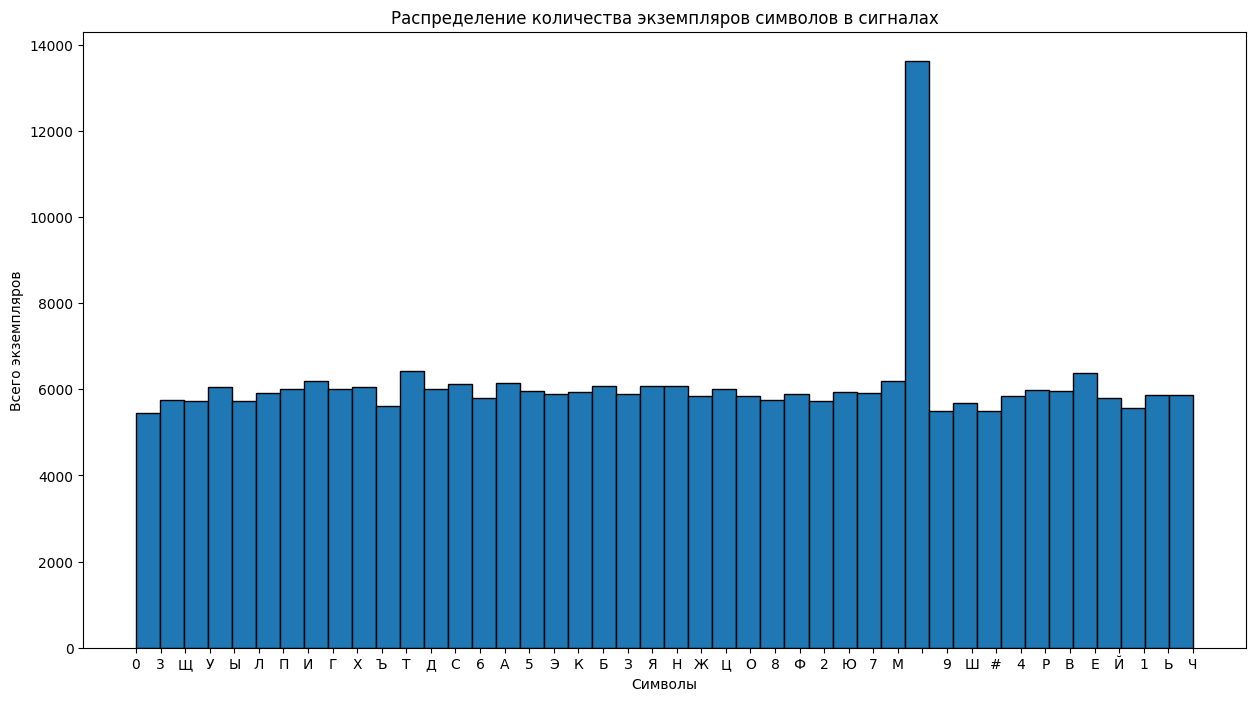

In [5]:
plt.figure(figsize=(15, 8))
plt.hist(list(m), bins=len(classes), edgecolor='black')
plt.title("Распределение количества экземпляров символов в сигналах")
plt.xlabel("Символы")
plt.ylabel("Всего экземпляров")
plt.show()

# Подготовка данных
Необходимо преобразовать аудиофайл в мел-спектрограмму, для того чтобы отделить сигнал морзе от внешних и внутренних шумов.
Это повысит точность предсказаний модели.

In [6]:
!pip install python-Levenshtein -q



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import butter, filtfilt, spectrogram
import pywt
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write as write_wav
import json
import Levenshtein as lv


Функции загрузки и сохранения сигнала, a также функция нормализации

In [8]:
def save_signal(y, path):

    serializable = y.tolist()
    
    with open(path, "w") as f:
        json.dump(serializable, f, indent=2)


def load_signal(path):
    with open(path, "r") as f:
        y = json.load(f)
    return np.array(y, dtype=np.float32)

def norm_signal(y, plot=False):

    min_val = np.min(y)
    max_val = np.max(y)
    
    if max_val == min_val:
        return np.zeros_like(y)  # если сигнал плоский — просто нули

    y_norm = 2 * (y - min_val) / (max_val - min_val) - 1
    x_norm = np.linspace(0, 8, num=len(y))
    
    if plot is True:
        plt.figure(figsize=(10, 4))
        plt.plot(x_norm, y_norm, color='red')
        plt.title("после нормализации")
        plt.show()
        
    return y_norm

### Преобразование аудиофайлов

#### Загружаем аудиофайл, при помощи библиотеки librosa получаем мел-спектрограмму;
#### Возводим значения массива во 2 степень для повышения контрастности сигнала на фоне шума;
#### Из полученного массива значений (256, 345) выделяем строку с наибольшими значениями звучания (в dB);
#### нормализуем полученные значения строки (1, 345) от -1 до 1;

Размерность итогового экземпляра датасета:  (345,)


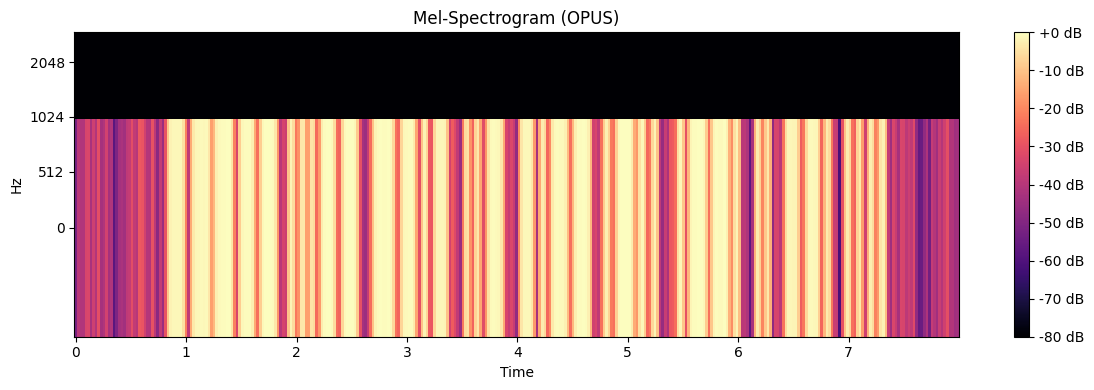

In [16]:
for i in range(0, 30000):
    y, sr = librosa.load(f"train/{i+1}.opus")
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=8000)
    S = S*S
    # Переводим в децибелы для визуализации
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = S_dB[int(np.argmax(S_dB)/S_dB.shape[1]):int(np.argmax(S_dB)/S_dB.shape[1]) + 2]
    S_dB[1] = -80 
    
    S_fin = norm_signal(S_dB[0])

    print("Размерность итогового экземпляра датасета: ", S_fin.shape)
    
    # Отображаем спектрограмму
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=2000, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram (OPUS)')
    plt.tight_layout()
    plt.show()
    break

#### Код для итогового преобразования датасета;
#### Формат экземпляра (.json): type = np.array, dtype = np.float32, shape = (345,)

In [96]:
for i in range(0, 30000):
    y, sr = librosa.load(f"train/{i+1}.opus")
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=8000)
    S = S*S
    # Переводим в децибелы для визуализации
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = S_dB[int(np.argmax(S_dB)/S_dB.shape[1]):int(np.argmax(S_dB)/S_dB.shape[1]) + 2]
    # S_dB[1] = -80 
    
    S_fin = norm_signal(S_dB[0])
    save_signal(S_fin, f"train_mel/{i}.json")
    

#### Подготовка таргетов
Сохраняем строки символов таргета как список в json-формате

In [24]:
import pandas as pd

def save_label(label, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(label, f, ensure_ascii=False, indent=2)
        
df = pd.read_csv('train.csv', delimiter=',')

for i in range(0,30000):
    save_label(list(df['message'].loc[i]), f"train_lab/{i}.json")

# Обучение модели
### Архитектура модели MorseNet - CNN + GRU.

Структура модели:
1. Вход (input)
Форма: (B, 1, 345)
Тип: одномерный сигнал длины 345, нормализованный, с одним каналом
B — размер батча
1 — канал (одномерный сигнал)
345 — длина входного сигнала

2. CNN-блок (self.cnn)
Сверточная часть извлекает пространственные признаки из сигнала:
Conv1d(1, 32, kernel_size=5, padding=2)
MaxPool1d(2) → длина сигнала: 345 → 172
Conv1d(32, 64, kernel_size=3, padding=1)
MaxPool1d(2) → длина сигнала: 172 → 86
Итого:
На выходе: (B, 64, 86) — 64 признака на каждом из 86 временных шагов.

3. GRU-блок (self.gru)
Двухслойная, двунаправленная рекуррентная сеть:
Вход: (B, 86, 64)
Выход: (B, 86, 256)
128 скрытых единиц * 2 (вперёд + назад)

4. Классификатор (self.classifier)
Linear(256, num_classes + 1)
+1 класс для CTC (для "blank")
Применяется к каждому временному шагу (после GRU)

5. Выход (output)
Форма: (B, 86, num_classes + 1)
Это логарифмы вероятностей (log_softmax) по всем классам для каждого временного шага

6. На выход применяем СТС-декодинг

In [19]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch
from torch.nn import CTCLoss
from torch.utils.data import DataLoader


def custom_collate(batch):
    return list(zip(*batch))

def load_signal(path):
    with open(path, "r") as f:
        y = json.load(f)
    return np.array(y, dtype=np.float32)

def create_vocab(char_list):
    char2idx = {c: i for i, c in enumerate(char_list)}
    idx2char = {i: c for c, i in char2idx.items()}
    return char2idx, idx2char

def load_label(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        label = json.load(f)
    return label

class MorseDataset(Dataset):
    def __init__(self, indices, char2idx,
                 signal_path='train_mel',
                 label_path='train_lab'):
        self.indices = indices
        self.char2idx = char2idx
        self.signal_path = signal_path
        self.label_path = label_path

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        signal = load_signal(f"{self.signal_path}/{i}.json")
        label = load_label(f"{self.label_path}/{i}.json")

        signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # (1, 345)
        label = torch.tensor([self.char2idx[c] for c in label], dtype=torch.long)
        return signal, label


class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        # После двух пуллингов размер сигнала: 345 -> ~86 (точнее: floor(345 / 4) = 86)

        self.gru = nn.GRU(
            input_size=64,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        self.classifier = nn.Linear(128 * 2, num_classes + 1)  # +1 для CTC blank

    def forward(self, x):
        x = self.cnn(x)              # (B, C, L)
        x = x.permute(0, 2, 1)       # (B, L, C)
        x, _ = self.gru(x)           # (B, L, 2*H)
        x = self.classifier(x)       # (B, L, C+1)
        return x.log_softmax(dim=-1) # (B, L, C+1)


def predict_single(signal_path, model, idx2char):
    model.eval()
    device = next(model.parameters()).device

    # Загрузка и подготовка сигнала
    signal = load_signal(signal_path)
    signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 345)
    signal = signal.to(device)

    with torch.no_grad():
        logits = model(signal)              # (1, T, C+1)
        pred = logits.argmax(dim=-1)        # (1, T)
        pred = pred.squeeze(0).cpu().numpy().tolist()

    # CTC-декодинг (удаление повторов и blank-индексов)
    blank_idx = len(idx2char)
    decoded = []
    prev = -1
    for p in pred:
        if p != prev and p != blank_idx:
            decoded.append(p)
        prev = p

    return ''.join([idx2char[i] for i in decoded])


def train_morsenet(path, file_indices):
    
    dataset = MorseDataset(file_indices, char2idx)
    loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=6, collate_fn=custom_collate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MorseNet(num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = CTCLoss(blank=num_classes, zero_infinity=True)
    print(device)
    
    for epoch in range(10):
        
        model.train()
        
        for signals, targets in loader:
            signals = torch.stack(signals).to(device)  # (B, 1, 345)
            logits = model(signals)                    # (B, T, C+1)
    
            input_lengths = torch.full((len(signals),), logits.size(1), dtype=torch.long)
            target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)
            targets = torch.cat(targets).to(device)
    
            logits = logits.permute(1, 0, 2)  # CTC expects (T, B, C)
            loss = criterion(logits, targets, input_lengths, target_lengths)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
        torch.save(model.state_dict(), path) # сохранялка

##### Тренировка модели

In [ ]:
char_list = list("АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789# ")
char2idx, idx2char = create_vocab(char_list)
num_classes = len(char2idx)

file_indices = list(range(29000))

train_morsenet('cnn_gru.pth', file_indices)

##### Предикт

In [ ]:
char_list = list("АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789# ")
char2idx, idx2char = create_vocab(char_list)
num_classes = len(char2idx)
path = "cnn_gru.pth"

model = MorseNet(num_classes=num_classes)
model.load_state_dict(torch.load(path, map_location="cpu"))
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

result = predict_single(f"train_mel/1.json", model, idx2char)
print(result)

# Получение метрики (расстояние Левенштейна)

In [34]:
df = pd.read_csv('train.csv', delimiter=',')
df_res = pd.read_csv('res.csv', index_col=False)
lev = 0
for i in range(0, 998):
    lev += lv.distance(df['message'].loc[29001+i], df_res['message'].loc[0+i])

print(lev/997)

0.2768304914744233
